# Plots for temperature anomalies

## Import dependencies and data

In [1]:
# import dependencies
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# set seaborn style/theme
sns.set_theme()
sns.set_style('white')

In [416]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

# drop all index levels except date
data = data.droplevel(
    level=[0, 1, 2], 
    axis=0
)

In [417]:
# keep only flow, setpoints, temps, pressure
data = data[[
    'flow',
    'temperatures',
    'setpoints',
    #'state',
    'pressure',
    'sun',
    'wind',
    #'humidity'
]].copy()

## Select and normalize variables

In [418]:
cols = [
    ('flow', 'TA01_GP101_default'),
    ('flow', 'TA01_SP102_absolute'),
    ('flow', 'DC_SP105_absolute'),
    ('flow', 'DC_SP106_absolute'),
    ('flow', 'DC_SP107_absolute'),
    ('flow', 'DC_SP110_absolute'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    #('humidity', 'TA01_GT10X_GM10X'),
    ('pressure', 'DC_GP101'),
    ('sun', 'SMHI_gsi'),
    ('sun', 'SMHI_vol'),
    ('wind', 'SMHI_speed'),
    ('setpoints', 'TA01_GT10X_GM10X_default'),
    ('setpoints', 'TA01_SP102_calculated')
]

data = data[cols].copy()

In [419]:
# remove level shift from setpoints change
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
                                                - (data.setpoints.TA01_GT10X_GM10X_default - 20.0)

In [420]:
# remove "OUTLIERS" from DC-TEMP
data[('temperatures', 'DC_GT401_GM401_bound')] = data.temperatures.DC_GT401_GM401.apply(lambda val: min(max(40.0, val), 50.0))

In [421]:
# smooth out w. rolling
data[('temperatures', 'DC_GT401_GM401_broll')] = \
    data.temperatures.DC_GT401_GM401_bound.rolling(window=20).mean()

In [422]:
# # calculate SUM of SP flows
# data[('flow', 'DC_SPSUM')] = \
#     data.flow.DC_SP105_absolute \
#     + data.flow.DC_SP106_absolute \
#     + data.flow.DC_SP107_absolute \
#     + data.flow.DC_SP110_absolute

In [423]:
# Interpolate hourly sun measurements

# # remove all "intermediary points"
# idx = pd.to_datetime(data.index.get_level_values(0).values).minute != 0
# data[('sun', 'SMHI_gsi')].loc[idx] = np.nan

# data.sun.SMHI_gsi = data.sun.SMHI_gsi.interpolate(method='spline', order=3)

In [424]:
# crop data
#data = data.iloc[-14400:].copy()
#data = data.iloc[-4000:].copy()
data = data.iloc[-2500:].copy()
#data = data.iloc[-1000:].copy()

# normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

## Plot temp/flow anomalies

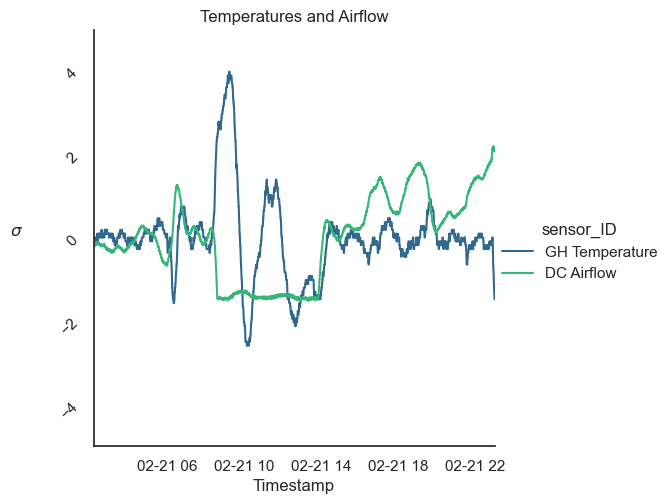

In [426]:
subset = data[[ # three last days of obs.
     ('temperatures', 'TA01_GT10X_GM10X'),
#      ('temperatures', 'DC_GT401_GM401'),
#     ('temperatures', 'DC_GT401_GM401_bound'),
#    ('temperatures', 'DC_GT401_GM401_broll'),
#      ('temperatures', 'DC_GT301_damped'),
#         ('sun', 'SMHI_gsi'),
#       ('sun', 'SMHI_vol'),
#      ('wind', 'SMHI_speed')
          ('flow', 'TA01_GP101_default'),
#]].iloc[-1000:].copy()
]].copy()

subset = subset.droplevel(level=0, axis=1)

subset = subset.rename(columns={
    'TA01_GT10X_GM10X':'GH Temperature',
    'DC_GT401_GM401':'DC',
    'DC_GT401_GM401_bound':'DC',
    'DC_GT401_GM401_broll':'DC',
    'TA01_GP101_default':'DC Airflow'
    
})

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='viridis',
    alpha= 1.0,
    linewidth=1.5,
    dashes=False,
    markers=False,
    legend='full',
)

ax.set_xticklabels(step=2)

plt.ylim(-5, 5)
plt.xlim(subset.index[0], subset.index[-1])
plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('$\sigma$', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('Temperatures and Airflow')

plt.savefig(plot_path + 'EXAMP_0.png', bbox_inches='tight', dpi=500)
plt.show()